In [1]:
## Module import
import pandas as pd
import numpy as np

from textblob import TextBlob
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

import csv
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

stpwrds = set(stopwords.words('english'))

In [2]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vishaljha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
new_sw = set()
with open('../Assets/StopWords_Generic.txt') as f:
    for line in f:
        new_sw.add(line.strip())

stpwrds = stpwrds.union(new_sw)
## Convert all stpwrds to lower case
stpwrds = {word.lower() for word in stpwrds}
len(stpwrds)

180

In [22]:
## Import data
data_loc = '../Data/'
df = pd.read_csv(data_loc + 'dogecoin_cleaned.csv')

In [23]:
## Function to tokenise and lemmatise tweets and remove stopwords
def tokenise_lemmatise(tweet):
    '''
    Function to tokenise and lemmatise tweets and remove stopwords
    '''
    tweet = tweet.lower()
    tokens = word_tokenize(tweet)
    tokens = [w for w in tokens if not w in stpwrds]
    tokens = [w for w in tokens if w.isalpha()]
    ps = PorterStemmer()
    tokens = [ps.stem(w) for w in tokens]
    wnl = WordNetLemmatizer()
    tokens = [wnl.lemmatize(w) for w in tokens]
    return tokens

df['tokens'] = df['tweet'].apply(tokenise_lemmatise)
df['tokens'] = df['tokens'].apply(lambda x: ' '.join(x))
df.head()

,date,timezone,tweet,nlikes,nreplies,nretweets,date_,time,tokens
0,2022-01-31 05:29:49,530,#ShibDoge The first community driven token cre...,2,0,1,2022-01-31,05:29:49,shibdog first commun driven token creat shiba ...
1,2022-01-31 05:29:40,530,January is over and what’s up #dogecoin what’s...,0,0,0,2022-01-31,05:29:40,januari dogecoin
2,2022-01-31 05:29:39,530,@BurgerKingUK What I’m telling you is that the...,4,0,0,2022-01-31,05:29:39,burgerkinguk tell dogefath would consid eat bu...
3,2022-01-31 05:29:16,530,You should be mega proud of yourself and your ...,0,0,0,2022-01-31,05:29:16,mega proud team love dogecoin
4,2022-01-31 05:28:45,530,"@Gotteeth23 Typical Dogecoin supporter, you ne...",0,0,0,2022-01-31,05:28:45,typic dogecoin support need onlyfan po


In [24]:
# USING LOUGHRAN MCDONALD'S MODEL TO NUMBER POSITIVE AND NEGATIVE TWEETS
word_dict_file = pd.read_csv('../Assets/LoughranMcDonald_MasterDictionary_2020.csv')

pos_word_list = []
neg_word_list = []
for i in range(len(word_dict_file)):
    if word_dict_file['Positive'][i] > 0:
        pos_word_list.append(word_dict_file['Word'][i])
    elif word_dict_file['Negative'][i] > 0:
        neg_word_list.append(word_dict_file['Word'][i])

pos_word_list = [x.lower() for x in pos_word_list]
neg_word_list = [x.lower() for x in neg_word_list]

print(len(pos_word_list))
print(len(neg_word_list))

347
2345


In [25]:
## Function to calculate the score (positive/negative) of the tweet using the word_dict
def calculate_score_helper(tweet):
    '''
    Utility function to calculate the score (positive/negative) of the tweet using the word_dict
    '''
    pos_score = 0
    neg_score = 0
    for word in tweet:
        if word in pos_word_list:
            pos_score += 1
        elif word in neg_word_list:
            neg_score += 1
    score = pos_score - neg_score
    return score

def calculate_score(df):
    '''
    Utility function to calculate the score (positive/negative) of the tweet using the word_dict
    '''
    df['LMD_score'] = df['tokens'].apply(calculate_score_helper)
    return df

df = calculate_score(df)
df.head()

,date,timezone,tweet,nlikes,nreplies,nretweets,date_,time,tokens,LMD_score
0,2022-01-31 05:29:49,530,#ShibDoge The first community driven token cre...,2,0,1,2022-01-31,05:29:49,shibdog first commun driven token creat shiba ...,0
1,2022-01-31 05:29:40,530,January is over and what’s up #dogecoin what’s...,0,0,0,2022-01-31,05:29:40,januari dogecoin,0
2,2022-01-31 05:29:39,530,@BurgerKingUK What I’m telling you is that the...,4,0,0,2022-01-31,05:29:39,burgerkinguk tell dogefath would consid eat bu...,0
3,2022-01-31 05:29:16,530,You should be mega proud of yourself and your ...,0,0,0,2022-01-31,05:29:16,mega proud team love dogecoin,0
4,2022-01-31 05:28:45,530,"@Gotteeth23 Typical Dogecoin supporter, you ne...",0,0,0,2022-01-31,05:28:45,typic dogecoin support need onlyfan po,0


In [26]:
## Function to calculate the sentiment of the tweet using TextBlob using polarity and subjectivity
def calculate_sentiment_helper(tweet):
    '''
    Utility function to calculate the sentiment of the tweet using TextBlob using polarity and subjectivity
    '''
    blob = TextBlob(tweet)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

def calculate_sentiment(df):
    '''
    Utility function to calculate the sentiment of the tweet using TextBlob using polarity and subjectivity
    '''
    df['sentiment_polarity'], df['sentiment_subjectivity'] = zip(*df['tokens'].apply(calculate_sentiment_helper))
    return df

df = calculate_sentiment(df)
df.head()

,date,timezone,tweet,nlikes,nreplies,nretweets,date_,time,tokens,LMD_score,sentiment_polarity,sentiment_subjectivity
0,2022-01-31 05:29:49,530,#ShibDoge The first community driven token cre...,2,0,1,2022-01-31,05:29:49,shibdog first commun driven token creat shiba ...,0,0.491667,0.538889
1,2022-01-31 05:29:40,530,January is over and what’s up #dogecoin what’s...,0,0,0,2022-01-31,05:29:40,januari dogecoin,0,0.000000,0.000000
2,2022-01-31 05:29:39,530,@BurgerKingUK What I’m telling you is that the...,4,0,0,2022-01-31,05:29:39,burgerkinguk tell dogefath would consid eat bu...,0,0.000000,0.000000
3,2022-01-31 05:29:16,530,You should be mega proud of yourself and your ...,0,0,0,2022-01-31,05:29:16,mega proud team love dogecoin,0,0.650000,0.800000
4,2022-01-31 05:28:45,530,"@Gotteeth23 Typical Dogecoin supporter, you ne...",0,0,0,2022-01-31,05:28:45,typic dogecoin support need onlyfan po,0,0.000000,0.000000


In [27]:
## Get a sentiment score from 0 to 1 for each tweet using the sentiment polarity and subjectivity
def get_sentiment_score(df):
    '''
    Get a sentiment score from 0 to 1 for each tweet using the sentiment polarity and subjectivity
    '''
    df['sentiment_score'] = df['sentiment_polarity'] + df['sentiment_subjectivity']
    return df

df = get_sentiment_score(df)
df.head()

,date,timezone,tweet,nlikes,nreplies,nretweets,date_,time,tokens,LMD_score,sentiment_polarity,sentiment_subjectivity,sentiment_score
0,2022-01-31 05:29:49,530,#ShibDoge The first community driven token cre...,2,0,1,2022-01-31,05:29:49,shibdog first commun driven token creat shiba ...,0,0.491667,0.538889,1.030556
1,2022-01-31 05:29:40,530,January is over and what’s up #dogecoin what’s...,0,0,0,2022-01-31,05:29:40,januari dogecoin,0,0.000000,0.000000,0.000000
2,2022-01-31 05:29:39,530,@BurgerKingUK What I’m telling you is that the...,4,0,0,2022-01-31,05:29:39,burgerkinguk tell dogefath would consid eat bu...,0,0.000000,0.000000,0.000000
3,2022-01-31 05:29:16,530,You should be mega proud of yourself and your ...,0,0,0,2022-01-31,05:29:16,mega proud team love dogecoin,0,0.650000,0.800000,1.450000
4,2022-01-31 05:28:45,530,"@Gotteeth23 Typical Dogecoin supporter, you ne...",0,0,0,2022-01-31,05:28:45,typic dogecoin support need onlyfan po,0,0.000000,0.000000,0.000000


In [28]:
## Get average sentiment score for each tweet using the LMD score and sentiment score
def get_average_sentiment_score(df):
    '''
    Get average sentiment score for each tweet using the LMD score and sentiment score
    '''
    df['avg_sentiment_score'] = (df['LMD_score'] + df['sentiment_score']) / 2
    return df

df = get_average_sentiment_score(df)
df.head()

,date,timezone,tweet,nlikes,nreplies,nretweets,date_,time,tokens,LMD_score,sentiment_polarity,sentiment_subjectivity,sentiment_score,avg_sentiment_score
0,2022-01-31 05:29:49,530,#ShibDoge The first community driven token cre...,2,0,1,2022-01-31,05:29:49,shibdog first commun driven token creat shiba ...,0,0.491667,0.538889,1.030556,0.515278
1,2022-01-31 05:29:40,530,January is over and what’s up #dogecoin what’s...,0,0,0,2022-01-31,05:29:40,januari dogecoin,0,0.000000,0.000000,0.000000,0.000000
2,2022-01-31 05:29:39,530,@BurgerKingUK What I’m telling you is that the...,4,0,0,2022-01-31,05:29:39,burgerkinguk tell dogefath would consid eat bu...,0,0.000000,0.000000,0.000000,0.000000
3,2022-01-31 05:29:16,530,You should be mega proud of yourself and your ...,0,0,0,2022-01-31,05:29:16,mega proud team love dogecoin,0,0.650000,0.800000,1.450000,0.725000
4,2022-01-31 05:28:45,530,"@Gotteeth23 Typical Dogecoin supporter, you ne...",0,0,0,2022-01-31,05:28:45,typic dogecoin support need onlyfan po,0,0.000000,0.000000,0.000000,0.000000


In [29]:
## Multiply the average sentiment score by nreplies and nretweets to get the final score, then normalise the score to -1 to 1
def get_final_score(df):
    '''
    Multiply the average sentiment score by nreplies and nretweets to get the final score, then normalise the score
    '''
    df['final_score'] = df['avg_sentiment_score'] * (df['nreplies'] + df['nretweets']/2)
    df['final_score'] = df['final_score'] / df['final_score'].abs().max()    
  
    return df

df = get_final_score(df)
df.head()

,date,timezone,tweet,nlikes,nreplies,nretweets,date_,time,tokens,LMD_score,sentiment_polarity,sentiment_subjectivity,sentiment_score,avg_sentiment_score,final_score
0,2022-01-31 05:29:49,530,#ShibDoge The first community driven token cre...,2,0,1,2022-01-31,05:29:49,shibdog first commun driven token creat shiba ...,0,0.491667,0.538889,1.030556,0.515278,0.000133
1,2022-01-31 05:29:40,530,January is over and what’s up #dogecoin what’s...,0,0,0,2022-01-31,05:29:40,januari dogecoin,0,0.000000,0.000000,0.000000,0.000000,0.000000
2,2022-01-31 05:29:39,530,@BurgerKingUK What I’m telling you is that the...,4,0,0,2022-01-31,05:29:39,burgerkinguk tell dogefath would consid eat bu...,0,0.000000,0.000000,0.000000,0.000000,0.000000
3,2022-01-31 05:29:16,530,You should be mega proud of yourself and your ...,0,0,0,2022-01-31,05:29:16,mega proud team love dogecoin,0,0.650000,0.800000,1.450000,0.725000,0.000000
4,2022-01-31 05:28:45,530,"@Gotteeth23 Typical Dogecoin supporter, you ne...",0,0,0,2022-01-31,05:28:45,typic dogecoin support need onlyfan po,0,0.000000,0.000000,0.000000,0.000000,0.000000


In [30]:
## Drop all cols except final_score, tweet, time and date
df = df[['final_score', 'tweet', 'time', 'date']]
df.head()

,final_score,tweet,time,date
0,0.000133,#ShibDoge The first community driven token cre...,05:29:49,2022-01-31 05:29:49
1,0.000000,January is over and what’s up #dogecoin what’s...,05:29:40,2022-01-31 05:29:40
2,0.000000,@BurgerKingUK What I’m telling you is that the...,05:29:39,2022-01-31 05:29:39
3,0.000000,You should be mega proud of yourself and your ...,05:29:16,2022-01-31 05:29:16
4,0.000000,"@Gotteeth23 Typical Dogecoin supporter, you ne...",05:28:45,2022-01-31 05:28:45


In [31]:
## Sort the dataframe by time
df = df.sort_values(by=['time'])
df.head()

,final_score,tweet,time,date
1275,0.000140,$TCT @wildcardp2e can't wait to play #wildcard...,00:00:00,2022-01-31 00:00:00
1276,0.000164,The current price of one Baby Doge Coin is: $0...,00:00:00,2022-01-31 00:00:00
6186,0.000123,The current price of one Baby Doge Coin is: $0...,00:00:00,2022-01-30 00:00:00
1274,0.000363,"The current price of one DOGE is now: $0.1412,...",00:00:03,2022-01-31 00:00:03
6185,0.000081,"The current price of one DOGE is now: $0.1421,...",00:00:03,2022-01-30 00:00:03


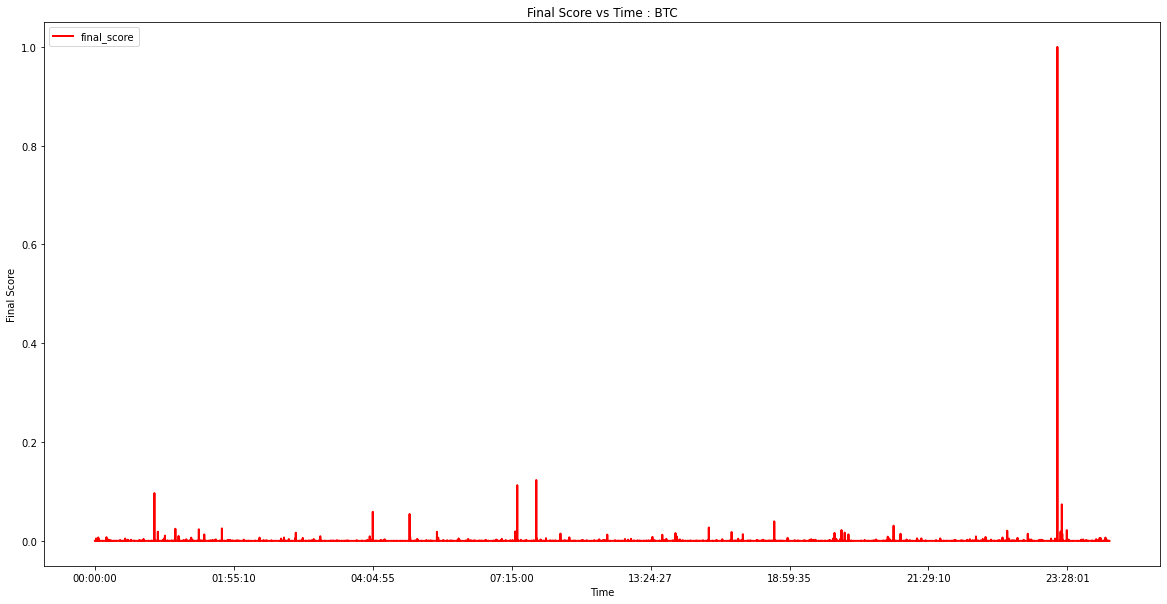

In [32]:
## Plot the final score vs time as a line graph using matplotlib
plot = df.plot(x='time', y='final_score', figsize=(20,10), color='red', linewidth=2, legend=True)
plot.set_xlabel('Time')
plot.set_ylabel('Final Score')
plot.set_title('Final Score vs Time : BTC')
plot.legend(loc='upper left')



In [33]:
## Calculate the average final score for every 1 minutes
def get_avg_final_score(df):
    '''
    Calculate the average final score for every 1 minutes
    '''
    df['1_min_window_score'] = df['final_score'].rolling(window=1).mean()
    return df
df = get_avg_final_score(df)
df.head()


,final_score,tweet,time,date,1_min_window_score
1275,0.000140,$TCT @wildcardp2e can't wait to play #wildcard...,00:00:00,2022-01-31 00:00:00,0.000140
1276,0.000164,The current price of one Baby Doge Coin is: $0...,00:00:00,2022-01-31 00:00:00,0.000164
6186,0.000123,The current price of one Baby Doge Coin is: $0...,00:00:00,2022-01-30 00:00:00,0.000123
1274,0.000363,"The current price of one DOGE is now: $0.1412,...",00:00:03,2022-01-31 00:00:03,0.000363
6185,0.000081,"The current price of one DOGE is now: $0.1421,...",00:00:03,2022-01-30 00:00:03,0.000081


In [34]:
## Calculate the average final score for every 1 hour
def get_avg_final_score(df):
    '''
    Calculate the average final score for every 1 hour
    '''
    df['1_hour_window_score'] = df['final_score'].rolling(window=60).mean()
    return df
df = get_avg_final_score(df)
df.head()

,final_score,tweet,time,date,1_min_window_score,1_hour_window_score
1275,0.000140,$TCT @wildcardp2e can't wait to play #wildcard...,00:00:00,2022-01-31 00:00:00,0.000140,NaN
1276,0.000164,The current price of one Baby Doge Coin is: $0...,00:00:00,2022-01-31 00:00:00,0.000164,NaN
6186,0.000123,The current price of one Baby Doge Coin is: $0...,00:00:00,2022-01-30 00:00:00,0.000123,NaN
1274,0.000363,"The current price of one DOGE is now: $0.1412,...",00:00:03,2022-01-31 00:00:03,0.000363,NaN
6185,0.000081,"The current price of one DOGE is now: $0.1421,...",00:00:03,2022-01-30 00:00:03,0.000081,NaN


In [35]:
df[1:100]

,final_score,tweet,time,date,1_min_window_score,1_hour_window_score
1276,0.000164,The current price of one Baby Doge Coin is: $0...,00:00:00,2022-01-31 00:00:00,0.000164,NaN
6186,0.000123,The current price of one Baby Doge Coin is: $0...,00:00:00,2022-01-30 00:00:00,0.000123,NaN
1274,0.000363,"The current price of one DOGE is now: $0.1412,...",00:00:03,2022-01-31 00:00:03,0.000363,NaN
6185,0.000081,"The current price of one DOGE is now: $0.1421,...",00:00:03,2022-01-30 00:00:03,0.000081,NaN
1273,0.000240,#Dogecoin in the Snow: Special Blizzard Editio...,00:00:04,2022-01-31 00:00:04,0.000240,NaN
...,...,...,...,...,...,...
1228,0.000000,3...2...1 Heart attack! #dogecoin #memes #cry...,00:11:49,2022-01-31 00:11:49,0.000000,0.000145
6139,0.002492,Sending a huge shoutout and lots of love to Gr...,00:12:01,2022-01-30 00:12:01,0.002492,0.000186
1227,0.000000,"@elonmusk ""Those who would trade their Dogecoi...",00:12:09,2022-01-31 00:12:09,0.000000,0.000186
6138,0.000000,Hey #dogeFam &amp; #dogeArmy if you know someo...,00:12:09,2022-01-30 00:12:09,0.000000,0.000186


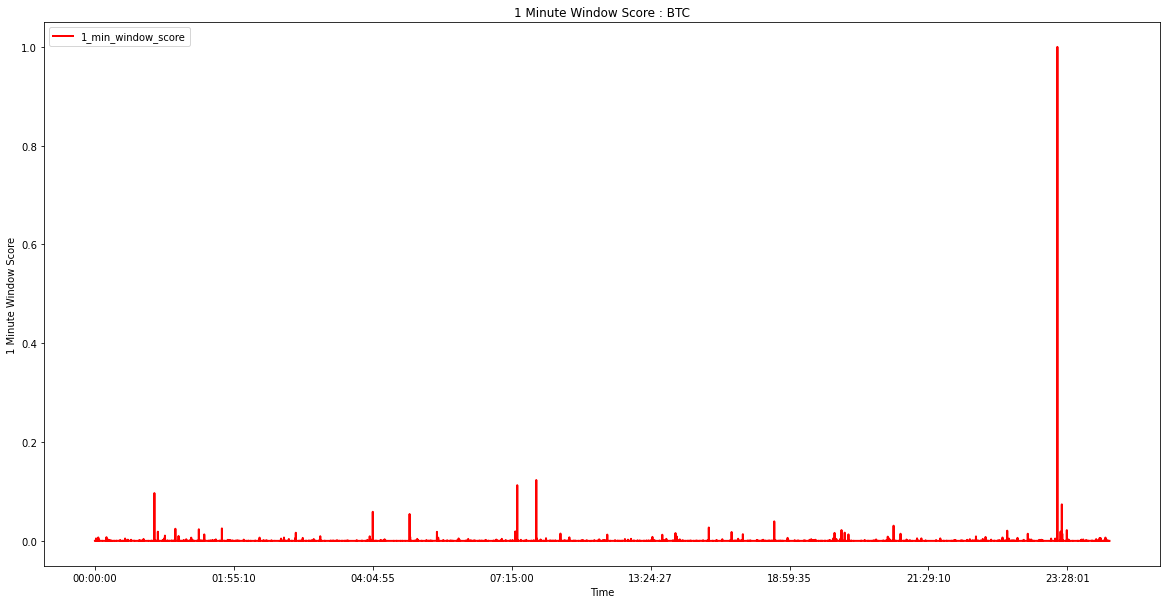

In [36]:
## Plot the 1 minute window score using matplotlib as a value vs time graph
plot = df.plot(x='time', y='1_min_window_score', figsize=(20,10), color='red', linewidth=2, legend=True)
plot.set_xlabel('Time')
plot.set_ylabel('1 Minute Window Score')
plot.set_title('1 Minute Window Score : BTC')
plot.legend(loc='upper left')

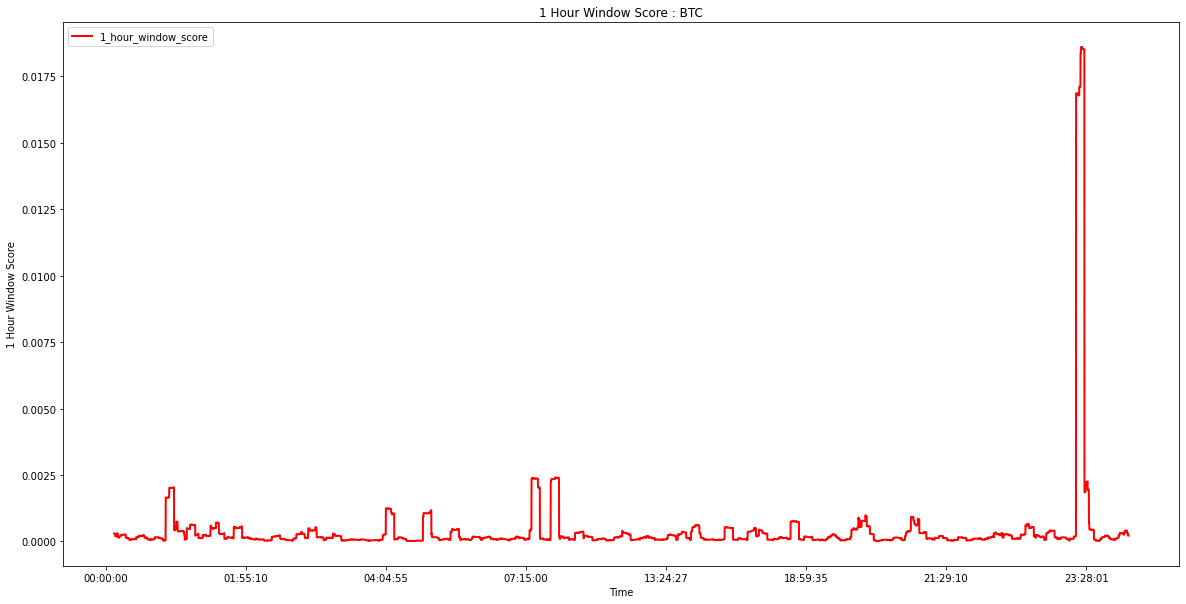

In [37]:
## Plot the 1 minute window score using matplotlib as a value vs time graph
plot = df.plot(x='time', y='1_hour_window_score', figsize=(20,10), color='red', linewidth=2, legend=True)
plot.set_xlabel('Time')
plot.set_ylabel('1 Hour Window Score')
plot.set_title('1 Hour Window Score : BTC')
plot.legend(loc='upper left')

In [38]:
## Export the dataframe to a csv file
df.to_csv('../Data/Dogecoin_final_score.csv', index=False)

In [39]:
df.head()

,final_score,tweet,time,date,1_min_window_score,1_hour_window_score
1275,0.000140,$TCT @wildcardp2e can't wait to play #wildcard...,00:00:00,2022-01-31 00:00:00,0.000140,NaN
1276,0.000164,The current price of one Baby Doge Coin is: $0...,00:00:00,2022-01-31 00:00:00,0.000164,NaN
6186,0.000123,The current price of one Baby Doge Coin is: $0...,00:00:00,2022-01-30 00:00:00,0.000123,NaN
1274,0.000363,"The current price of one DOGE is now: $0.1412,...",00:00:03,2022-01-31 00:00:03,0.000363,NaN
6185,0.000081,"The current price of one DOGE is now: $0.1421,...",00:00:03,2022-01-30 00:00:03,0.000081,NaN
